# Deep learning-based automated rock classification via high-resolution drone-captured core sample imagery
***
### Domenico M. Crisafulli, Misael M. Morales, and Carlos Torres-Verdin
#### The University of Texas at Austin, 2024
***

## Build and Train NN-classifier
| Class             | OLD   | New   |
| ---               | ---   | ---   |
| Background        | 0     | 0     |
| Sandstone type 1  | 1     | 2     |
| Shaly Rock        | 2     | 3     |
| Sandstone type 2  | 3     | 4     |
| Carbonate         | 4     | 5     |
| Shale             | 5     | 6     |
| Sandstone type 3  | 6     | 7     |
| Box               | 10    | 1     |

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import tensorflow as tf
import keras
import keras.backend as K
from keras import Model
from keras import layers
from keras import optimizers
from keras.applications.resnet import ResNet50, preprocess_input

def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*60+'\n')
    return None

check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.16.1 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.0 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [3]:
X_data = np.load('data/x_images.npy')
y_data = np.load('data/y_images.npy')
print('X: {} | y: {}'.format(X_data.shape, y_data.shape))

X: (1573, 512, 512, 1) | y: (1573, 512, 512, 1)


In [4]:
def DeeplabV3Plus(image_size, num_classes):
    def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, use_bias=False):
        x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", 
                          use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def DilatedSpatialPyramidPooling(dspp_input):
        dims = dspp_input.shape
        x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
        x = convolution_block(x, kernel_size=1, use_bias=True)
        out_pool = layers.UpSampling2D(
            size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)
        out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
        out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
        out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
        out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
        x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
        output = convolution_block(x, kernel_size=1)
        return output

    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    preprocessed = preprocess_input(model_input)
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=512, num_classes=10)
print('# params: {:,}'.format(model.count_params()))

2024-07-21 23:35:28.481603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:35:28.481709: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:35:28.481736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:35:28.680737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:35:28.680803: I external/local_xla/xla/stream_executor

# params: 11,854,666


In [5]:
idx = np.random.choice(range(len(X_data)), len(X_data), replace=False)
n_train = int(len(idx) * 0.8)
X_data = np.repeat(X_data, 3, axis=-1)

X_train, y_train = X_data[idx[:n_train]], y_data[idx[:n_train]]
X_test,  y_test  = X_data[idx[n_train:]], y_data[idx[n_train:]]
print('X - train: {} | test: {}'.format(X_train.shape, X_test.shape))
print('y - train: {} | test: {}'.format(y_train.shape, y_test.shape))

X - train: (1258, 512, 512, 3) | test: (315, 512, 512, 3)
y - train: (1258, 512, 512, 1) | test: (315, 512, 512, 1)


In [19]:
model = DeeplabV3Plus(image_size=512, num_classes=1)
model.compile(optimizer=optimizers.AdamW(1e-3, 4e-6), loss="binary_crossentropy", metrics=["accuracy"])

fit = model.fit(X_train, y_train,
                batch_size       = 8,
                epochs           = 20,
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 1)

model.save_weights('rockClassification.weights.h5')
pd.DataFrame(fit.history).to_csv('fit_history.csv', index=False)

2024-07-21 23:39:45.624423: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3164602368 exceeds 10% of free system memory.


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 148s 635ms/step - accuracy: 0.8215 - loss: -1.8482 - val_accuracy: 0.8815 - val_loss: 9.8732
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.8038 - loss: -4.1238 - val_accuracy: 0.0140 - val_loss: 6.1289
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accuracy: 0.7873 - loss: -1.8240 - val_accuracy: 0.0755 - val_loss: 4.0357
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.8455 - loss: -4.4050 - val_accuracy: 0.8815 - val_loss: 1.2725
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.8619 - loss: -4.8215 - val_accuracy: 0.8815 - val_loss: 1.4149
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 247ms/step - accuracy: 0.8656 - loss: -4.8506 - val_accuracy: 0.8815 - val_loss: 2.4830
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.8765 - loss: -4.7586 - val_accuracy: 0.8815 - val_loss: 1.3794
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8681 - 

In [ ]:
pd.DataFrame(fit.history).to_csv('fit_history.csv', index=False)

In [ ]:
plt.figure(figsize=(7,4))
n_epochs = range(len(fit.history)+1)
plt.plot(n_epochs, fit.history['accuracy'], label='Accuracy')
plt.plot(n_epochs, fit.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(edgecolor='k', facecolor='lightgrey')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [10]:
model = DeeplabV3Plus(image_size=512, num_classes=1)
model.load_weights('rockClassification.weights.h5')

In [11]:
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred  = model.predict(X_test, verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

2024-07-21 23:36:42.585375: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3957325824 exceeds 10% of free system memory.
2024-07-21 23:36:44.351014: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3957325824 exceeds 10% of free system memory.
I0000 00:00:1721623006.887364  137560 service.cc:145] XLA service 0x7f6b04003980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721623006.887451  137560 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-21 23:36:46.976101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 23:36:47.324494: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


 1/40 ━━━━━━━━━━━━━━━━━━━━ 22:07 34s/step

I0000 00:00:1721623039.531887  137560 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 734ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step 
Pred - train: (1258, 512, 512, 1) | test: (315, 512, 512, 1)


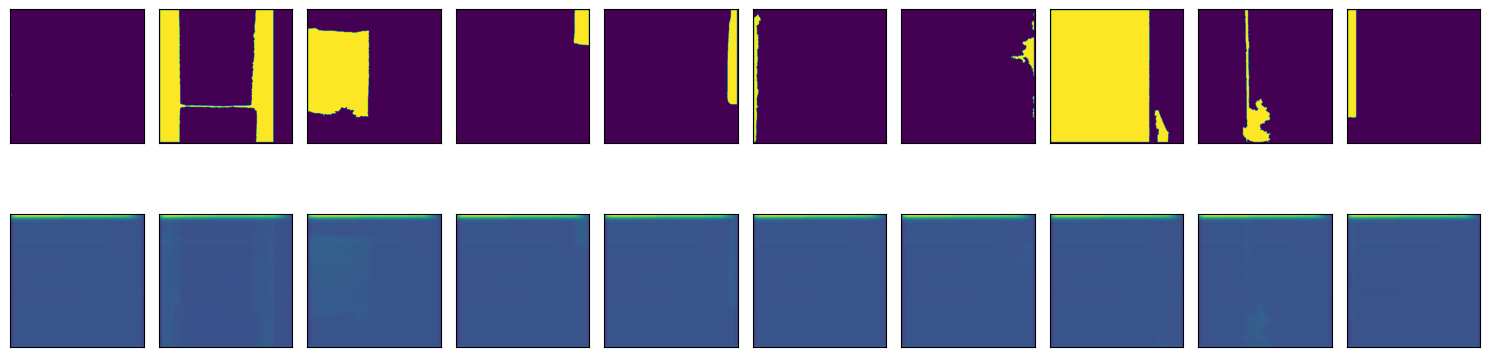

In [12]:
fig, axs = plt.subplots(2, 10, figsize=(15,5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2 = axs[0,j], axs[1,j]
    ax1.imshow(y_train[j])
    ax2.imshow(y_train_pred[j])
    [a.set(xticks=[], yticks=[]) for a in [ax1, ax2]]
plt.tight_layout()
plt.show()

***
# END